In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np


In [3]:
# Cargar dataset con ingeniería aplicada
file_path = "HR_Em_Attrition_Engineered.csv"
df = pd.read_csv(file_path)


In [4]:
# Separar variables predictoras y target

X = df.drop(columns=['Attrition'])
y = df['Attrition']

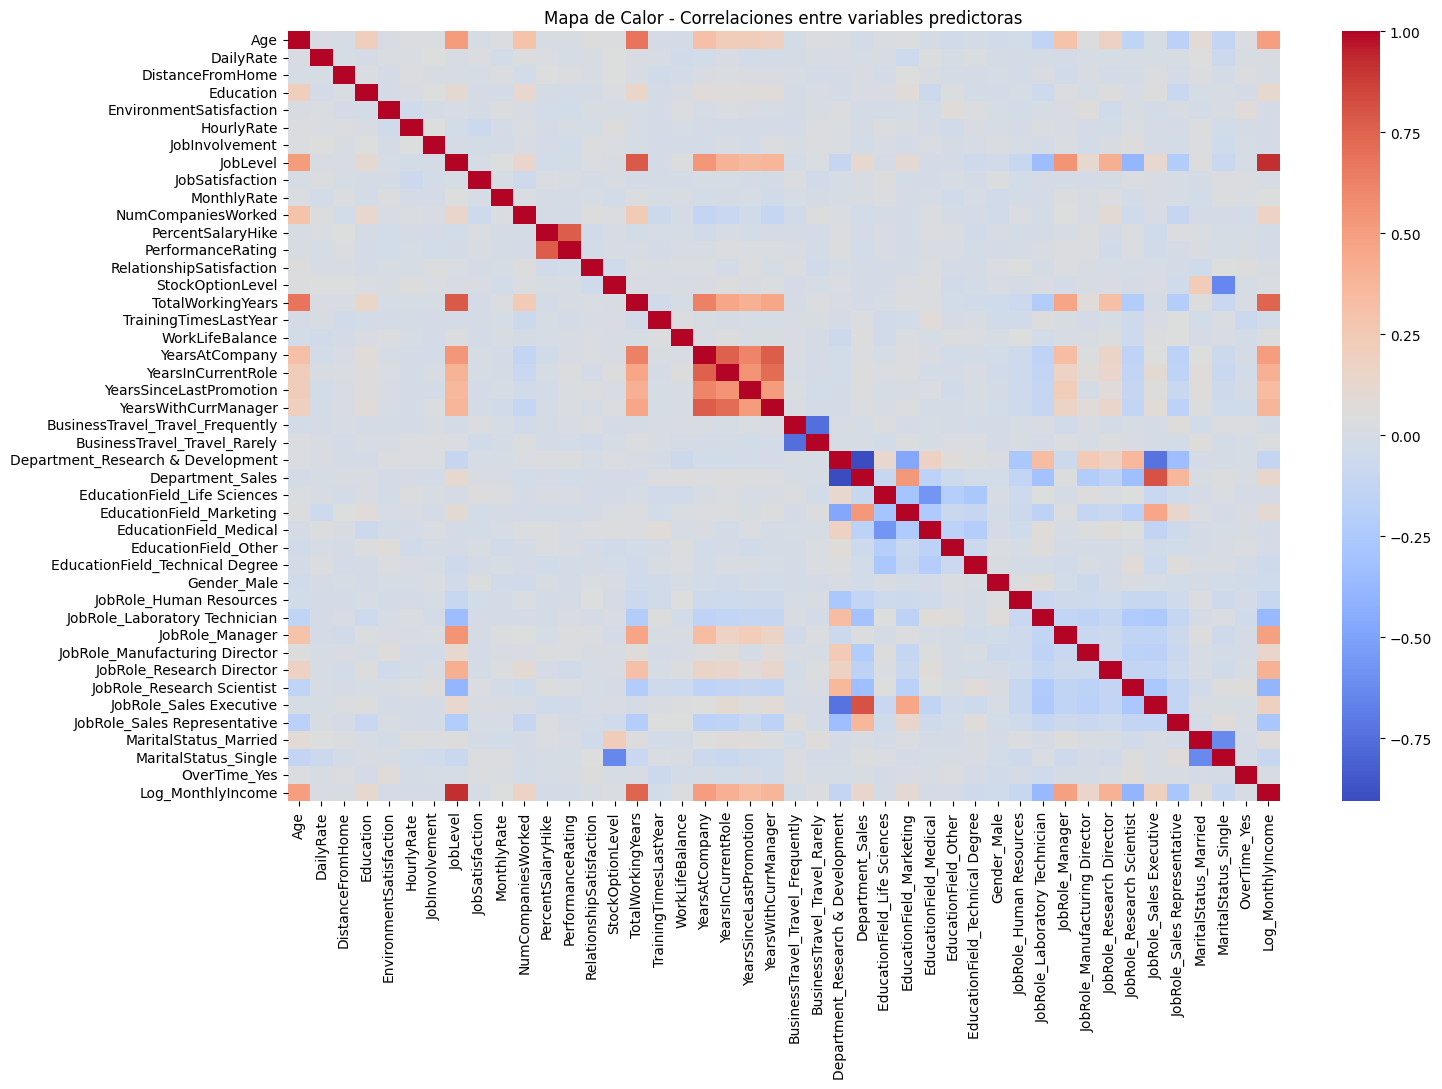

In [7]:
# %%
plt.figure(figsize=(16, 10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title("Mapa de Calor - Correlaciones entre variables predictoras")
plt.show()


In [6]:
# ### 3. Feature importance por coeficientes de regresión logística

# %%
# Estandarizar variables numéricas para comparación justa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Mostrar las 15 variables más importantes
importance_df.head(15)

,Feature,Coefficient
42,OverTime_Yes,0.896460
22,BusinessTravel_Travel_Frequently,0.722340
43,Log_MonthlyIncome,-0.712672
20,YearsSinceLastPromotion,0.543602
41,MaritalStatus_Single,0.514244
10,NumCompaniesWorked,0.506292
4,EnvironmentSatisfaction,-0.483763
18,YearsAtCompany,0.476508
21,YearsWithCurrManager,-0.449176
8,JobSatisfaction,-0.441954


In [8]:
# ### 4. Cálculo de WoE e IV para evaluación más rigurosa


def calculate_woe_iv(df, feature, target):
    eps = 0.0001
    lst = []
    for val in df[feature].unique():
        good = len(df[(df[feature] == val) & (df[target] == 0)])
        bad = len(df[(df[feature] == val) & (df[target] == 1)])
        dist_good = good / (len(df[df[target] == 0]) + eps)
        dist_bad = bad / (len(df[df[target] == 1]) + eps)
        woe = np.log((dist_good + eps) / (dist_bad + eps))
        iv = (dist_good - dist_bad) * woe
        lst.append({'Value': val, 'WOE': woe, 'IV': iv})
    return pd.DataFrame(lst).sort_values(by='IV', ascending=False), sum(item['IV'] for item in lst)

# Calcular IV para todas las variables dummy
woe_iv_summary = {}
for col in X.columns:
    if set(df[col].unique()) <= {0, 1}:
        _, iv = calculate_woe_iv(df, col, 'Attrition')
        woe_iv_summary[col] = iv

# Mostrar top 10 variables con mayor IV
iv_df = pd.DataFrame.from_dict(woe_iv_summary, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
iv_df.head(10)


,IV
OverTime_Yes,0.400085
MaritalStatus_Single,0.211455
JobRole_Sales Representative,0.132284
JobRole_Research Director,0.112992
BusinessTravel_Travel_Frequently,0.086297
JobRole_Manager,0.079063
JobRole_Manufacturing Director,0.068973
JobRole_Laboratory Technician,0.063339
MaritalStatus_Married,0.062895
Department_Research & Development,0.051762


### 7. Análisis de los resultados de selección de variables
# 
**Heatmap de correlación:**
El heatmap permite identificar relaciones fuertes entre variables. Se observó correlación alta entre pares como `TotalWorkingYears` y `YearsAtCompany`, lo que sugiere evitar usarlas juntas. Otras variables clave como `OverTime_Yes` y `JobLevel` tienen correlación baja con otras, lo que las hace valiosas para incluir.

**Coeficientes de regresión logística:**
Se detectaron como más influyentes `OverTime_Yes`, `BusinessTravel_Travel_Frequently` y `Log_MonthlyIncome`, todos con coeficientes absolutos altos. Esto refleja su fuerte asociación con la probabilidad de rotación en el modelo lineal.

**WoE + IV:**
Variables como `OverTime_Yes` (IV=0.40) y `MaritalStatus_Single` (IV=0.21) muestran fuerte capacidad discriminativa entre quienes rotan y quienes no. Se identificaron variables de JobRole y BusinessTravel con IV entre 0.06 y 0.13, útiles pero con menor poder predictivo.

Este análisis combinado refuerza la selección estratégica de variables para construir modelos robustos y comparables.